In [1]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 32.6 MB/s eta 0:00:00:00:0100:01


In [2]:
import os

# Создаем структуру папок
os.makedirs("src/deer/datasets", exist_ok=True)
os.makedirs("src/deer/language_models", exist_ok=True)
os.makedirs("src/deer/retrieval_strategies", exist_ok=True)

In [3]:
%%writefile src/deer/language_models/local_hf_model.py

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from deer.base import LanguageModel, LMOutput
from tqdm import tqdm


class LocalHFModel(LanguageModel):
    def __init__(self, model_name):
        super().__init__(model_name)
        print(f"Loading local model: {model_name}...")
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_quant_type="nf4",
        )
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token   
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            quantization_config=bnb_config,
            device_map="auto",
            trust_remote_code=True
        )
        self.model.eval()

    def generate(self, prompt_list, temperature=0.0, max_tokens=256, stop=None, batch_size=4, **kwargs):
        responses = []
        for i in tqdm(range(0, len(prompt_list), batch_size), desc="Local Inference"):
            batch_prompts = prompt_list[i : i + batch_size]
            formatted_batch = []
            for prompt in batch_prompts:
                messages = [{"role": "user", "content": prompt}]
                try:
                    text = self.tokenizer.apply_chat_template(
                        messages, 
                        tokenize=False, 
                        add_generation_prompt=True,
                        enable_thinking=False
                    )
                except TypeError:
                    text = self.tokenizer.apply_chat_template(
                        messages, 
                        tokenize=False, 
                        add_generation_prompt=True
                    )
                formatted_batch.append(text)
            inputs = self.tokenizer(formatted_batch, return_tensors="pt", padding=True, truncation=True).to("cuda")
            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_new_tokens=max_tokens,
                    temperature=temperature if temperature > 0 else 0.01,
                    do_sample=(temperature > 0),
                    pad_token_id=self.tokenizer.eos_token_id,
                    eos_token_id=self.tokenizer.eos_token_id,
                )
            decoded = self.tokenizer.batch_decode(outputs[:, inputs.input_ids.shape[1]:], skip_special_tokens=True)
            for text in decoded:
                responses.append(LMOutput(text=text))     
        return responses

Writing src/deer/language_models/local_hf_model.py


In [4]:
%%writefile src/deer/core.py
from deer.language_models.local_hf_model import LocalHFModel

def run_inference(task, args):
    model_type = args.model_type
    model_name = args.model_name
    task.load_retriever()
    task.generate_icl_prompts()
    prompt_list = task.get_icl_prompt()
    model = LocalHFModel(model_name)
    response_list = model.generate(
        prompt_list=prompt_list,
        temperature=args.temperature,
        max_tokens=args.max_tokens,
        batch_size=args.batch_size
    )
    task.update_icl_results(response_list)
    task.save_results()

def run_reflection(task, args):
    pass

Writing src/deer/core.py


In [5]:
%%writefile src/deer/base.py

import os
from abc import ABC, abstractmethod
from typing import Any, List, NamedTuple, Optional
import numpy as np

class EmbeddingModel(ABC):
    def __init__(self, model_name: str):
        self.model_name = model_name
    @abstractmethod
    def generate_embedding(self, texts: List[str], **kwargs) -> List[Any]:
        pass

class LMOutput(NamedTuple):
    text: list[str]
    logprobs: Optional[list[np.ndarray]] = None

class LanguageModel(ABC):
    def __init__(self, model_name: str):
        self.model_name = model_name
    @abstractmethod
    def generate(self, prompt_list: List[str], **kwargs) -> List[LMOutput]:
        pass

class Retriever(ABC):
    def __init__(self, retrieval_data, num_examples, seed=42):
        self.retrieval_data = retrieval_data
        self.num_examples = num_examples
        self.seed = seed
    @abstractmethod
    def retrieve(self):
        pass

class TaskItem(ABC):
    def __init__(self, item: dict):
        self.split = item.get('split', None)
        self.id = item.get('id', None)
    def to_dict(self):
        return {"split": self.split, "id": self.id}

class Task(ABC):
    def __init__(self, args):
        self.args = args
        self.train_data = None
        self.eval_data = None
    def get_data_path(self, data_dir, data_split: str) -> str:
        return os.path.join(data_dir, f'{data_split}.jsonl')
    @abstractmethod
    def load_data(self): pass

Writing src/deer/base.py


In [6]:
with open("src/deer/__init__.py", "w") as f: f.write("from .base import Task\nfrom .core import run_inference")

In [7]:
%%writefile src/deer/task.py

import os
import re
import json
import copy
import numpy as np
from collections import defaultdict, Counter
from deer.base import Task, TaskItem
from deer.language_models.huggingface_emb_model import HFUncontextualizedTokenEmbeddingModel
from deer.retrieval_strategies.token_embedding_retriever import DEERRetriever

class NERItem(TaskItem):
    def __init__(self, item: dict, context_len: int):
        super().__init__(item)
        self.tokens = item.get('tokens')
        self.ent_list = item.get('ent_list')
        self.sentence = item.get('sentence', ' '.join(self.tokens) if self.tokens else None)
        self.token_embeddings = item.get('token_embeddings', None)
        self.sentence_embedding = item.get('sentence_embedding', None)
        self.icl_prompt = None
        self.llm_response = None
        self.ent_list_pred = None
        self.entity_span_dict, self.context_span_dict, self.other_span_dict = self.build_span_dict(context_len)

    def build_span_dict(self, context_len):
        entity_span_dict = defaultdict(list)
        context_span_dict = defaultdict(list)
        other_span_dict = defaultdict(list)
        entity_token_idx_list = []
        context_token_idx_list = []
        for ent in self.ent_list:
            ent_idx = ent['token_idx']
            ent_span = self.tokens[ent_idx[0]:ent_idx[1]+1]
            start_ctx = max(0, ent_idx[0]-context_len)
            end_ctx = min(len(self.tokens), ent_idx[1]+1+context_len)
            ent_cxt_span = self.tokens[start_ctx:end_ctx]
            for i in range(ent_idx[0], ent_idx[1]+1):
                token = self.tokens[i]
                entity_span_dict[token].append({
                    'id': self.id, 'token': token, 'ent_type': ent['type'], 
                    'ent_span': ent_span, 'ent_cxt_span': ent_cxt_span
                })
                entity_token_idx_list.append(i)
        entity_token_idx_list = sorted(list(set(entity_token_idx_list)))
        for ent in self.ent_list:
            ent_idx = ent['token_idx']
            start_ctx = max(0, ent_idx[0]-context_len)
            end_ctx = min(len(self.tokens), ent_idx[1]+1+context_len)
            ent_cxt_span = self.tokens[start_ctx:end_ctx]
            ent_span = self.tokens[ent_idx[0]:ent_idx[1]+1]
            left_range = range(start_ctx, ent_idx[0])
            right_range = range(ent_idx[1]+1, end_ctx)
            for idx in list(left_range) + list(right_range):
                if idx not in entity_token_idx_list:
                    token = self.tokens[idx]
                    context_span_dict[token].append({
                        'id': self.id, 'token': token, 'ent_type': ent['type'], 
                        'ent_span': ent_span, 'ent_cxt_span': ent_cxt_span
                    })
                    context_token_idx_list.append(idx)
        used_indices = set(entity_token_idx_list + context_token_idx_list)
        for idx, token in enumerate(self.tokens):
            if idx not in used_indices:
                other_span = self.tokens[max(0, idx-context_len):min(len(self.tokens), idx+1+context_len)]
                other_span_dict[token].append({
                    'id': self.id, 'token': token, 'ent_type': None, 'ent_cxt_span': other_span
                })     
        return entity_span_dict, context_span_dict, other_span_dict

    def build_icl_prompt(self, template_name, template, examples):
        examples_str = []
        for ex in examples:
            out = {"named entities": [{"name": e['name'], "type": e['type']} for e in ex.ent_list]}
            examples_str.append(f"Input: {ex.sentence}\nOutput: {json.dumps(out)}")
        ex_block = "\n\n".join(examples_str)
        self.icl_prompt = template.replace("{{input_sentence}}", self.sentence).replace("{{icl_examples}}", ex_block)

    def update_results(self, template_name, response):
        self.llm_response = response.text
        try:
            text = response.text
            if "```json" in text:
                text = text.split("```json")[1].split("```")[0]
            elif "```" in text:
                text = text.split("```")[0]
            
            match = re.search(r'(\{.*\})', text, re.DOTALL)
            if match:
                js = json.loads(match.group(1))
                self.ent_list_pred = js.get("named entities", [])
            else:
                self.ent_list_pred = []
        except:
            self.ent_list_pred = []

    def to_dict(self):
        d = super().to_dict()
        d.update({
            "sentence": self.sentence, 
            "ent_list": self.ent_list, 
            "ent_list_pred": self.ent_list_pred, 
            "llm_response": self.llm_response
        })
        return d

class NER(Task):
    def __init__(self, args):
        super().__init__(args)
        self.args = args
        self.context_len = args.context_len
        self.prompt_template = None
        self.load_data()
        self.emb_model = HFUncontextualizedTokenEmbeddingModel(args.emb_model_name)

    def load_data(self):
        train_path = self.get_data_path(f"data/{self.args.data_name}", "train")
        eval_path = self.get_data_path(f"data/{self.args.data_name}", self.args.eval_split)
        with open(train_path, "r") as f:
            self.train_data = [NERItem(json.loads(line), self.context_len) for line in f]
        with open(eval_path, "r") as f:
            self.eval_data = [NERItem(json.loads(line), self.context_len) for line in f]
            if self.args.eval_num: 
                self.eval_data = self.eval_data[:self.args.eval_num]
    
    def load_retriever(self):
        print("Initializing DEER Retriever...")
        self.retriever = DEERRetriever(self.train_data, self.eval_data, self.args)

    def generate_icl_prompts(self):
        for item in self.eval_data:
            examples = self.retriever.retrieve(item)
            item.build_icl_prompt(self.args.prompt_template_name, self.prompt_template, examples)

    def get_icl_prompt(self):
        return [item.icl_prompt for item in self.eval_data]

    def update_icl_results(self, responses):
        for item, resp in zip(self.eval_data, responses):
            item.update_results(self.args.prompt_template_name, resp)

    def save_results(self):
        path = f"{self.args.output_dir}/results.jsonl"
        os.makedirs(os.path.dirname(path), exist_ok=True)
        with open(path, "w") as f:
            for item in self.eval_data:
                d = item.to_dict()
                if 'token_embeddings' in d: del d['token_embeddings']
                if 'sentence_embedding' in d: del d['sentence_embedding']
                f.write(json.dumps(d) + "\n")
        print(f"Results saved to {path}")

Writing src/deer/task.py


In [8]:
%%writefile src/deer/language_models/huggingface_emb_model.py

import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
from tqdm import tqdm
from deer.base import EmbeddingModel

class HFUncontextualizedTokenEmbeddingModel(EmbeddingModel):
    def __init__(self, model_name):
        super().__init__(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def generate_embedding(self, texts, batch_size=32, sleep_time=0, **kwargs):
        vocab = set()
        for t in texts: vocab.update(t.split())
        vocab = list(vocab)
        vocab_embeddings = {}
        for i in tqdm(range(0, len(vocab), 128), desc="Embedding Vocab"):
            batch = vocab[i:i+128]
            inputs = self.tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(self.device)
            with torch.no_grad():
                outputs = self.model(**inputs)
                embs = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
            for token, emb in zip(batch, embs):
                vocab_embeddings[token] = emb
        embeddings = []
        for text in texts:
            embeddings.append(np.array([vocab_embeddings.get(t, np.zeros(embs.shape[1])) for t in text.split()]))
        return embeddings, vocab_embeddings

Writing src/deer/language_models/huggingface_emb_model.py


In [9]:
%%writefile src/deer/retrieval_strategies/token_embedding_retriever.py

import numpy as np
import torch
from collections import Counter, defaultdict
from tqdm import tqdm
from deer.base import Retriever
from deer.language_models.huggingface_emb_model import HFUncontextualizedTokenEmbeddingModel

class DEERRetriever(Retriever):
    def __init__(self, demo_data, query_data, args):
        self.demo_data = demo_data
        self.query_data = query_data
        self.icl_demo_num = args.icl_demo_num
        self.alpha_token_match = args.alpha_token_match
        self.alpha_embed_sim = args.alpha_embed_sim
        self.entity_weight = args.entity_weight
        self.context_weight = args.context_weight
        self.other_weight = args.other_weight 
        self.context_len = args.context_len
        
        print("Collecting token statistics from training data...")
        self.collect_token_distributions(self.demo_data)
        print("Generating embeddings using Local HF Model...")
        self.emb_model = HFUncontextualizedTokenEmbeddingModel(args.emb_model_name)
        demo_sentences = [d.sentence for d in self.demo_data]
        demo_embs_batch, vocab_embs = self.emb_model.generate_embedding(demo_sentences)
        for item, emb in zip(self.demo_data, demo_embs_batch):
            item.token_embeddings = emb
        query_sentences = [d.sentence for d in self.query_data]
        query_embs_batch, _ = self.emb_model.generate_embedding(query_sentences)
        for item, emb in zip(self.query_data, query_embs_batch):
            item.token_embeddings = emb
        self.demo_sen_embs = self.calc_weighted_sent_embs(self.demo_data)
        self.demo_norms = np.linalg.norm(self.demo_sen_embs, axis=1)
        self.demo_norms[self.demo_norms == 0] = 1e-10

    def collect_token_distributions(self, data):
        self.token_counts = defaultdict(lambda: [0, 0, 0])
        self.token_source_dict = defaultdict(list)
        
        for idx, item in enumerate(data):
            for token in item.entity_span_dict:
                self.token_counts[token][0] += len(item.entity_span_dict[token])
                self.token_source_dict[token].append((idx, 'ent'))
                
            for token in item.context_span_dict:
                self.token_counts[token][1] += len(item.context_span_dict[token])
                self.token_source_dict[token].append((idx, 'ctx'))
                
            for token in item.other_span_dict:
                self.token_counts[token][2] += len(item.other_span_dict[token])
                self.token_source_dict[token].append((idx, 'oth'))

        self.token_weights_map = {}
        for token, counts in self.token_counts.items():
            total = sum(counts)
            if total == 0: 
                self.token_weights_map[token] = [0, 0, 1.0]
                continue
            
            p_ent = counts[0] / total
            p_ctx = counts[1] / total
            p_oth = counts[2] / total
            
            w_score = (self.entity_weight * p_ent) + (self.context_weight * p_ctx) + (self.other_weight * p_oth)
            self.token_weights_map[token] = w_score

    def get_token_weight(self, token):
        return self.token_weights_map.get(token, 1.0)

    def calc_weighted_sent_embs(self, data):
        sent_embs = []
        for item in data:
            weights = [self.get_token_weight(t) for t in item.tokens]
            weights = np.array(weights)
            if np.sum(weights) == 0:
                weights = np.ones(len(weights)) / len(weights)
            else:
                weights = weights / np.sum(weights)
            
            weighted_avg = np.average(item.token_embeddings, axis=0, weights=weights)
            sent_embs.append(weighted_avg)
            
        return np.array(sent_embs)

    def retrieve(self, query_item):
        q_weights = [self.get_token_weight(t) for t in query_item.tokens]
        q_weights = np.array(q_weights)
        if np.sum(q_weights) > 0: q_weights = q_weights / np.sum(q_weights)
        else: q_weights = np.ones(len(q_weights)) / len(q_weights)
            
        q_emb = np.average(query_item.token_embeddings, axis=0, weights=q_weights)
        q_norm = np.linalg.norm(q_emb)
        if q_norm == 0: q_norm = 1e-10
        dot_products = np.dot(self.demo_sen_embs, q_emb)
        sim_scores = dot_products / (self.demo_norms * q_norm)
        match_scores = np.zeros(len(self.demo_data))
        for token in set(query_item.tokens):
            if token not in self.token_source_dict:
                continue
            token_val = self.get_token_weight(token)
            relevant_doc_idxs = set([x[0] for x in self.token_source_dict[token]])
            for doc_idx in relevant_doc_idxs:
                match_scores[doc_idx] += token_val
        final_scores = (self.alpha_embed_sim * sim_scores) + (self.alpha_token_match * match_scores)
        top_idxs = np.argsort(final_scores)[-self.icl_demo_num:]
        return [self.demo_data[i] for i in reversed(top_idxs)]

Writing src/deer/retrieval_strategies/token_embedding_retriever.py


In [10]:
%%writefile src/deer/datasets/conll03.py
from deer.task import NER
ICL_JSON_FORMAT = '''Identify "PER", "LOC", "ORG", "MISC" entities.
JSON Template: {"named entities": [{"name": "ent_name", "type": "ent_type"}]}

{{icl_examples}}

Input: {{input_sentence}}
Output: '''

class CONLL03(NER):
    def __init__(self, args):
        super().__init__(args)
        self.prompt_template = ICL_JSON_FORMAT

Writing src/deer/datasets/conll03.py


In [11]:
import json
import os
import requests
from tqdm import tqdm

OUTPUT_DIR = "data/conll03"
os.makedirs(OUTPUT_DIR, exist_ok=True)

URLS = {
    "train": "https://raw.githubusercontent.com/patverga/torch-ner-nlp-from-scratch/master/data/conll2003/eng.train",
    "dev": "https://raw.githubusercontent.com/patverga/torch-ner-nlp-from-scratch/master/data/conll2003/eng.testa",
    "test": "https://raw.githubusercontent.com/patverga/torch-ner-nlp-from-scratch/master/data/conll2003/eng.testb"
}

TYPE_MAP = { "PER": "PER", "ORG": "ORG", "LOC": "LOC", "MISC": "MISC" }

def parse_conll_file(file_path):
    data = []
    with open(file_path, "r", encoding="utf-8") as f:
        tokens = []
        tags = []
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    data.append({"tokens": tokens, "ner_tags": tags})
                    tokens = []
                    tags = []
                continue
            if line.startswith("-DOCSTART-"):
                continue
            parts = line.split()
            if len(parts) < 4: continue
            word = parts[0]
            tag = parts[3]
            tokens.append(word)
            tags.append(tag)   
        if tokens:
            data.append({"tokens": tokens, "ner_tags": tags})
    return data

def convert_bio_to_spans(tokens, tags):
    ents = []
    curr = None
    for i, (t, tag) in enumerate(zip(tokens, tags)):
        if tag == "O":
            if curr: ents.append(curr); curr = None
            continue
        prefix, type_raw = tag.split("-", 1)
        tag_type = TYPE_MAP.get(type_raw, type_raw)
        if prefix == "B":
            if curr: ents.append(curr)
            curr = {"name": t, "type": tag_type, "token_idx": [i, i]}
        elif prefix == "I" and curr and curr["type"] == tag_type:
            curr["name"] += " " + t
            curr["token_idx"][1] = i
        else:
            if curr: ents.append(curr)
            curr = {"name": t, "type": tag_type, "token_idx": [i, i]}      
    if curr: ents.append(curr)
    return ents

def download_file(url, save_path):
    print(f"Downloading {os.path.basename(save_path)}...")
    response = requests.get(url, stream=True)
    with open(save_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

raw_dir = "raw_conll"
os.makedirs(raw_dir, exist_ok=True)
download_file(URLS["train"], f"{raw_dir}/train.txt")
download_file(URLS["dev"], f"{raw_dir}/dev.txt")
download_file(URLS["test"], f"{raw_dir}/test.txt")

for split in ['train', 'dev', 'test']:
    raw_path = f"{raw_dir}/{split}.txt"
    jsonl_name = "train.jsonl" if split == 'train' else ("dev.jsonl" if split == 'dev' else "test.jsonl")
    print(f"Converting {split} to {jsonl_name}...")
    parsed_data = parse_conll_file(raw_path)
    if split == 'train': parsed_data = parsed_data[:1000]
    if split == 'test': parsed_data = parsed_data[:50]
    with open(os.path.join(OUTPUT_DIR, jsonl_name), "w") as f:
        for i, item in enumerate(parsed_data):
            ents = convert_bio_to_spans(item['tokens'], item['ner_tags'])
            obj = {
                "id": str(i), 
                "tokens": item['tokens'], 
                "ent_list": ents, 
                "sentence": " ".join(item['tokens'])
            }
            f.write(json.dumps(obj) + "\n")

print("Data preparation complete.")

Converting train to train.jsonl...
Converting dev to dev.jsonl...
Converting test to test.jsonl...
Data preparation complete.


In [12]:
import argparse
import sys
sys.path.append("src")

from deer.datasets.conll03 import CONLL03
from deer.core import run_inference

class Args:
    data_name = "conll03"
    output_dir = "output_kaggle"
    icl_demo_retrieval_method = "deer"
    icl_demo_num = 4
    context_len = 2
    alpha_token_match = 1.0
    alpha_embed_sim = 1.0
    entity_weight = 1.0
    context_weight = 0.5
    other_weight = 0.01 
    emb_model_name = "bert-base-uncased"
    emb_model_type = "huggingface"
    model_type = "local_hf"
    model_name = "Qwen/Qwen3-8B"
    prompt_template_name = "icl_json_format"
    prompt_template = None 
    eval_split = "test"
    eval_num = 50 
    batch_size = 4
    temperature = 0.1 
    max_tokens = 512
    icl_inference = True
    async_mode = False
    stop = None
    response_format = "json"
    logprobs = False
    sleep_time = 0

args = Args()

print(f"Initializing Task with model: {args.model_name}...")
task = CONLL03(args)

print("Starting Inference (DEER)...")
run_inference(task, args)

print("Done! Results saved to output_kaggle/results.jsonl")

Initializing Task with model: Qwen/Qwen3-8B...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

2025-12-18 14:19:47.317998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766067587.494889      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766067587.551516      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766067587.992204      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766067587.992257      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766067587.992260      55 computation_placer.cc:177] computation placer alr

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Starting Inference (DEER)...
Initializing DEER Retriever (Full Logic)...
Generating embeddings using Local HF Model...


Embedding Vocab: 100%|██████████| 4/4 [00:00<00:00, 23.43it/s]


Loading local model: Qwen/Qwen3-8B...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.19G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Local Inference: 100%|██████████| 13/13 [06:44<00:00, 31.14s/it]

Results saved to output_kaggle/results.jsonl
Done! Results saved to output_kaggle/results.jsonl


In [13]:
import argparse
import sys
sys.path.append("src")
from deer.datasets.conll03 import CONLL03
from deer.core import run_inference

class KateArgs:
    data_name = "conll03"
    output_dir = "output_kate"
    icl_demo_retrieval_method = "deer" 
    alpha_token_match = 0.0
    alpha_embed_sim = 1.0
    entity_weight = 0.0
    context_weight = 0.0
    other_weight = 0.0 
    icl_demo_num = 4
    context_len = 2
    emb_model_name = "bert-base-uncased"
    emb_model_type = "huggingface"
    model_type = "local_hf"
    model_name = "Qwen/Qwen3-8B" 
    prompt_template_name = "icl_json_format"
    prompt_template = None
    eval_split = "test"
    eval_num = 50 
    batch_size = 4
    temperature = 0.1
    max_tokens = 512
    icl_inference = True; async_mode = False; stop = None; response_format = "json"; logprobs = False; sleep_time = 0

args_kate = KateArgs()

print("Initializing Task (KATE Baseline)...")
task_kate = CONLL03(args_kate)

print("Starting Inference (KATE)...")
run_inference(task_kate, args_kate)

print("KATE Done! Results saved to output_kate/results.jsonl")

Initializing Task (KATE Baseline)...
Starting Inference (KATE)...
Initializing DEER Retriever (Full Logic)...
Generating embeddings using Local HF Model...


Embedding Vocab: 100%|██████████| 4/4 [00:00<00:00, 21.60it/s]


Loading local model: Qwen/Qwen3-8B...


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Local Inference: 100%|██████████| 13/13 [09:37<00:00, 44.39s/it]

Results saved to output_kate/results.jsonl
KATE Done! Results saved to output_kate/results.jsonl


Method     | F1     | Prec   | Rec   
-----------------------------------
KATE       | 78.70 | 82.58 | 75.17
DEER       | 89.26 | 86.93 | 91.72
-----------------------------------
Impact of DEER Strategy: +10.56% F1


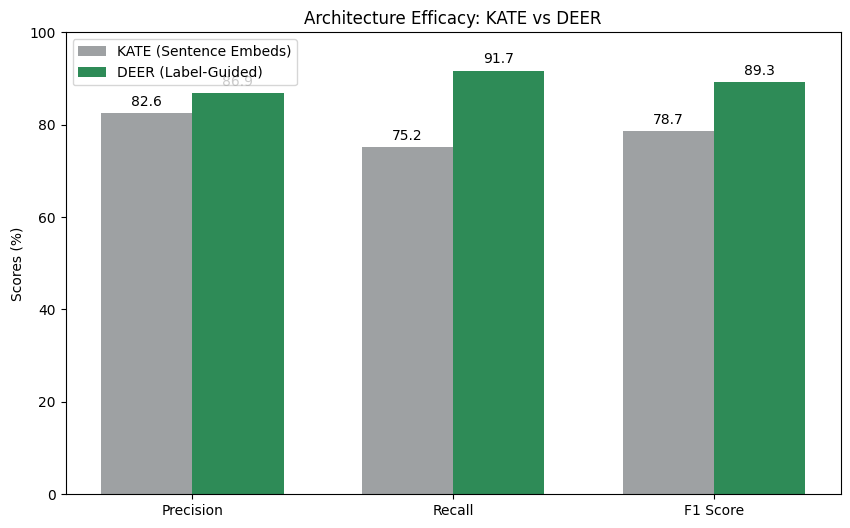

In [14]:
import json
import matplotlib.pyplot as plt
import os
import numpy as np

def get_metrics_from_file(path):
    if not os.path.exists(path): return 0.0, 0.0, 0.0
    
    tps, fps, fns = 0, 0, 0
    with open(path) as f:
        for line in f:
            item = json.loads(line)
            golds = item['ent_list']
            preds = item.get('ent_list_pred', [])
            
            if not isinstance(preds, list): preds = []
            
            gold_set = set([(e['name'], e['type']) for e in golds if isinstance(e, dict)])
            pred_set = set([(e['name'], e['type']) for e in preds if isinstance(e, dict)])
            
            tps += len(gold_set & pred_set)
            fps += len(pred_set - gold_set)
            fns += len(gold_set - pred_set)
            
    precision = tps / (tps + fps) if (tps + fps) > 0 else 0
    recall = tps / (tps + fns) if (tps + fns) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return precision*100, recall*100, f1*100

p_deer, r_deer, f1_deer = get_metrics_from_file("output_kaggle/results.jsonl")
p_kate, r_kate, f1_kate = get_metrics_from_file("output_kate/results.jsonl")

print(f"{'Method':<10} | {'F1':<6} | {'Prec':<6} | {'Rec':<6}")
print("-" * 35)
print(f"{'KATE':<10} | {f1_kate:.2f} | {p_kate:.2f} | {r_kate:.2f}")
print(f"{'DEER':<10} | {f1_deer:.2f} | {p_deer:.2f} | {r_deer:.2f}")
print("-" * 35)
diff = f1_deer - f1_kate
print(f"Impact of DEER Strategy: {diff:+.2f}% F1")

labels = ['Precision', 'Recall', 'F1 Score']
kate_scores = [p_kate, r_kate, f1_kate]
deer_scores = [p_deer, r_deer, f1_deer]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, kate_scores, width, label='KATE (Sentence Embeds)', color='#9ea1a3')
rects2 = ax.bar(x + width/2, deer_scores, width, label='DEER (Label-Guided)', color='#2e8b57')

ax.set_ylabel('Scores (%)')
ax.set_title('Architecture Efficacy: KATE vs DEER')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 100)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

# Видим что действительно использование совпадений ключевых сущнсотей дает прирост